In [ ]:
import pandas as pd
# show all columns when printing
pd.set_option('display.max_columns', None)
import numpy as np
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
df = pd.read_csv("/content/passengers_enriched_2023_prepared.csv")

In [ ]:
df.head()

,station_uid,line,farezones,entrytapcount,exittapcount,year,month,day,day_of_year,month_sin,month_cos,day_of_year_sin,day_of_year_cos,is_weekend,is_event,expected_attendance,max_temp,min_temp,mean_temp,precipitation_amount,relative_humidity,cloud_cover,sunshine_duration,sea_level_pressure,service_operated_allweek_pct,service_operated_weekday_pct,service_operated_weekend_pct,kilometres_operated,wifi,bluebadgecarparking,bluebadgecarparkspaces,toilet_isaccessible,toilet_isfeecharged
0,910GACTNCTL,mildmay,3,779,709,2023,1,1,1,0.5,0.866025,0.017213,0.999852,True,0,0.0,13.4,5.2,7.2,4.6,81.0,7.0,0.0,1008.0,90.201755,90.905127,88.184147,190892.969975,True,False,0.0,unknown,unknown
1,910GACTNCTL,mildmay,3,1077,1135,2023,1,2,2,0.5,0.866025,0.034422,0.999407,False,0,0.0,13.4,5.2,7.2,0.4,86.0,3.0,5.2,1016.9,90.201755,90.905127,88.184147,190892.969975,True,False,0.0,unknown,unknown
2,910GACTNCTL,mildmay,3,735,597,2023,1,3,3,0.5,0.866025,0.051620,0.998667,False,0,0.0,13.9,2.1,7.8,3.0,93.0,7.0,0.0,1018.6,90.201755,90.905127,88.184147,190892.969975,True,False,0.0,unknown,unknown
3,910GACTNCTL,mildmay,3,818,735,2023,1,4,4,0.5,0.866025,0.068802,0.997630,False,0,0.0,13.5,9.2,11.6,0.2,82.0,6.0,0.4,1014.6,90.201755,90.905127,88.184147,190892.969975,True,False,0.0,unknown,unknown
4,910GACTNCTL,mildmay,3,1237,1247,2023,1,5,5,0.5,0.866025,0.085965,0.996298,False,0,0.0,12.7,8.9,11.2,2.4,82.0,8.0,0.4,1018.6,90.201755,90.905127,88.184147,190892.969975,True,False,0.0,unknown,unknown


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147103 entries, 0 to 147102
Data columns (total 33 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   station_uid                   147103 non-null  object 
 1   line                          147103 non-null  object 
 2   farezones                     147103 non-null  object 
 3   entrytapcount                 147103 non-null  int64  
 4   exittapcount                  147103 non-null  int64  
 5   year                          147103 non-null  int64  
 6   month                         147103 non-null  int64  
 7   day                           147103 non-null  int64  
 8   day_of_year                   147103 non-null  int64  
 9   month_sin                     147103 non-null  float64
 10  month_cos                     147103 non-null  float64
 11  day_of_year_sin               147103 non-null  float64
 12  day_of_year_cos               147103 non-nul

In [ ]:
#fórmula para obtener la suma de nulos
print(df.isnull().sum().sort_values(ascending=False))

expected_attendance             2318
station_uid                        0
line                               0
entrytapcount                      0
farezones                          0
year                               0
month                              0
day                                0
exittapcount                       0
day_of_year                        0
month_sin                          0
day_of_year_sin                    0
month_cos                          0
day_of_year_cos                    0
is_weekend                         0
is_event                           0
max_temp                           0
min_temp                           0
mean_temp                          0
precipitation_amount               0
relative_humidity                  0
cloud_cover                        0
sunshine_duration                  0
sea_level_pressure                 0
service_operated_allweek_pct       0
service_operated_weekday_pct       0
service_operated_weekend_pct       0
k

In [ ]:
df["expected_attendance"].fillna(df["expected_attendance"].median(), inplace=True)

/tmp/ipython-input-735662859.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["expected_attendance"].fillna(df["expected_attendance"].median(), inplace=True)


# 1. Definir el target y sus características

In [ ]:
target = "entrytapcount"
features = df.drop(columns=[target, "exittapcount"])  # evitamos fuga de info

# 2. Identificar tipos de variables

In [ ]:
categorical_cols = features.select_dtypes(include=["object", "bool"]).columns.tolist()
numeric_cols = features.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 3. Tratamiento de nulos con imputer

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))  # imputación con mediana
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # imputación con moda
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer, numeric_cols)
    ]
)

# 4. Definir Pipeline con Random Forest

In [ ]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# 5. Dividir train/test y entrenar modelo

In [ ]:
# Dividir train/test
X_train, X_test, y_train, y_test = train_test_split(
    features, df[target],
    test_size=0.2,
    random_state=42
)

# Entrenar el modelo (el pipeline ya incluye imputación + codificación + random forest)
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['station_uid', 'line',
                                                   'farezones', 'is_weekend',
                                                   'wifi',
                                                   'bluebadgecarparking',
                                                   'toilet_isaccessible',
                                                   'toilet_isfeecharged']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   Si...
                                                   'expected_attendance',
                                                   'max_temp', 'min_temp',
                                                   'mean_temp',
                                                   'precipitation_amount',
                                                   'relative_humidity',
                                                   'cloud_cover',
                                                   'sunshine_duration',
                                                   'sea_level_pressure',
                                                   'service_operated_allweek_pct',
                                                   'service_operated_weekday_pct',
                                                   'service_operated_weekend_pct',
                                                   'kilometres_operated',
                                                   'bluebadgecarparkspaces'])])),
                ('regressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

# 6. Evaluación del modelo

In [ ]:
# Predicciones
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Métricas en training
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Métricas en test
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Mostrar resultados
print("=== Resultados en TRAIN ===")
print(f"RMSE: {train_rmse:.2f}")
print(f"MAE : {train_mae:.2f}")
print(f"R²  : {train_r2:.2f}")

print("\n=== Resultados en TEST ===")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE : {test_mae:.2f}")
print(f"R²  : {test_r2:.2f}")

# 9. Check de Overfitting

r2_diff = train_r2 - test_r2

print("\nOverfitting Analysis:")
print(f"  R² (train): {train_r2:.4f}")
print(f"  R² (test) : {test_r2:.4f}")
print(f"  R² difference (train - test): {r2_diff:.4f}")

if r2_diff > 0.1:
    print("  ⚠️ Possible overfitting detected")
elif r2_diff > 0.05:
    print("  ⚡ Slight overfitting")
else:
    print("  ✅ No significant overfitting")

=== Resultados en TRAIN ===
RMSE: 527.26
MAE : 232.85
R²  : 1.00

=== Resultados en TEST ===
RMSE: 1423.55
MAE : 634.31
R²  : 0.98

Overfitting Analysis:
  R² (train): 0.9971
  R² (test) : 0.9782
  R² difference (train - test): 0.0189
  ✅ No significant overfitting


# 7. Gráfico comparativo de predicciones vs valores reales

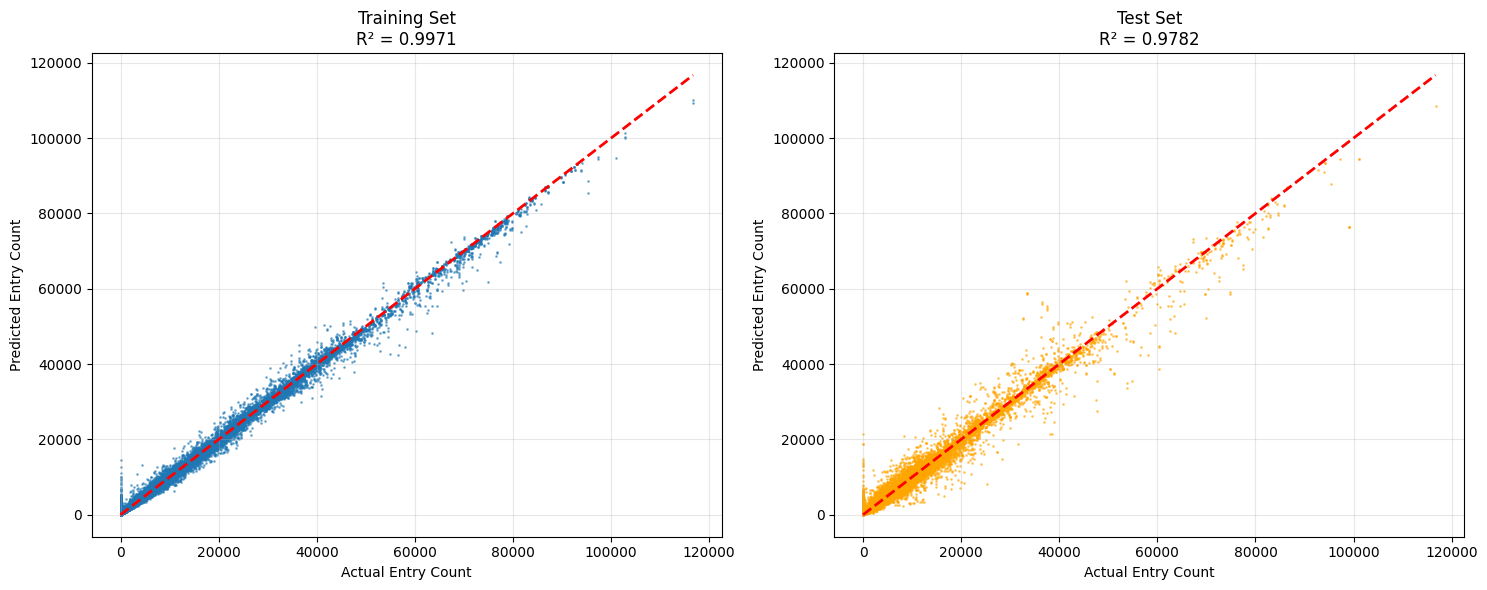

In [ ]:
import matplotlib.pyplot as plt

# Prediction vs Actual scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training set
ax1.scatter(y_train, y_train_pred, alpha=0.5, s=1)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Entry Count')
ax1.set_ylabel('Predicted Entry Count')
ax1.set_title(f'Training Set\nR² = {train_r2:.4f}')
ax1.grid(True, alpha=0.3)

# Test set
ax2.scatter(y_test, y_test_pred, alpha=0.5, s=1, color='orange')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Entry Count')
ax2.set_ylabel('Predicted Entry Count')
ax2.set_title(f'Test Set\nR² = {test_r2:.4f}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. Análisis de Residuos

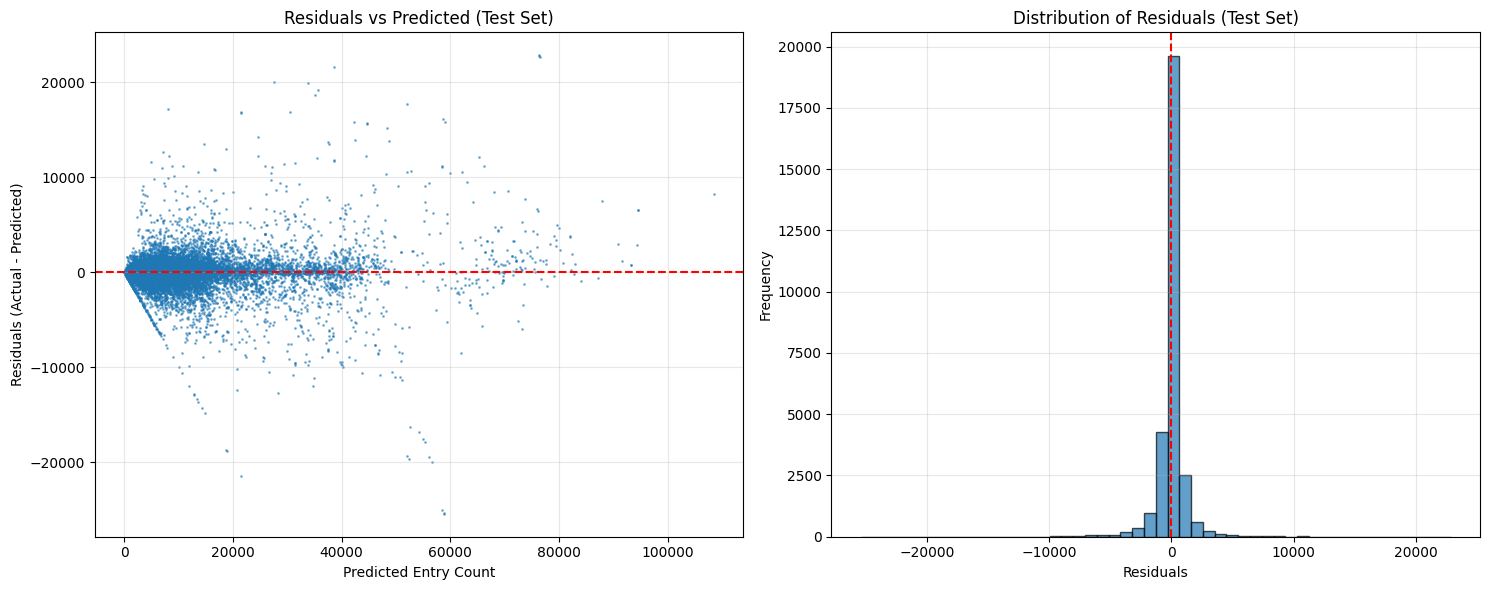

Residual Statistics (Test Set):
  Mean: 0.48
  Std:  1423.57
  Min:  -25448.93
  Max:  22865.44


In [ ]:
# Residual analysis
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Residuals vs Predicted
ax1.scatter(y_test_pred, residuals_test, alpha=0.5, s=1)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted Entry Count')
ax1.set_ylabel('Residuals (Actual - Predicted)')
ax1.set_title('Residuals vs Predicted (Test Set)')
ax1.grid(True, alpha=0.3)

# Residuals histogram
ax2.hist(residuals_test, bins=50, alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='r', linestyle='--')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Residuals (Test Set)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics (Test Set):")
print(f"  Mean: {residuals_test.mean():.2f}")
print(f"  Std:  {residuals_test.std():.2f}")
print(f"  Min:  {residuals_test.min():.2f}")
print(f"  Max:  {residuals_test.max():.2f}")